# **Analyse des Avis Clients Air France avec des techniques de NLP**

---

*Erra PASCALE*

### **Contexte du Projet**  


L’ensemble de données**Air France Revies** regroupe des avis clients collectés de manière éthique vi**apify.c**, en respectant les directives de scraping et les normes de confidentialité. Toutes le**informations personnelles identifiables (PI** ont été supprimées afin de garantir une analyse sécurisée et conforme aux réglementations en vigueur.  

L’objectif principal de ce projet est double :  
1. **Identifier les mots-clés caractéristiques des avis positifs et négtifs**, afin de mieux comprendre les facteurs influençant la satisfaction ou l’insatisfaction des passagers. 
2. **Développer un modèle de Machine Lerning** capabl de **prédire automatiquement le sentment** d’un client à partir de son commentaire après un ance. 🚀

![Description de l'image](https://www.klia2.info/images/airlines/air-france-flight.jpg)


## 1 - **Partie Data Quality**

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1.1 Etape 1 : Exploration

In [1]:
types = {
    "rating": np.int64,
    "title": str,
    "text": str,
    "publishedDate": str
}

Review = pd.read_csv("airfrance_tripadvisor_reviews.csv", dtype=types)
Review['publishedDate'] = pd.to_datetime(Review['publishedDate'], errors='coerce')

# On va uniquement utiliser le titre
Review['text'] = Review['title'] # + " , " + Review['text']
Review.head()

NameError: name 'np' is not defined

In [378]:
Review.shape

(2560, 4)

In [380]:
Review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   rating         2560 non-null   int64         
 1   title          2560 non-null   object        
 2   text           2560 non-null   object        
 3   publishedDate  2560 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 80.1+ KB


Nombre d'observations unique par colonnes.

In [383]:
for i in Review.columns:
    print(i,":",Review[i].nunique())

rating : 5
title : 2391
text : 2391
publishedDate : 602


In [385]:
Review.duplicated().sum()

1

Aucune observations dupliquées.

In [388]:
Review[['text', 'title', 'rating', 'publishedDate']].isna().sum()

text             0
title            0
rating           0
publishedDate    0
dtype: int64

Les variables `text` et `rating` ne contiennent aucunes valeurs manquantes.

### Visualisations

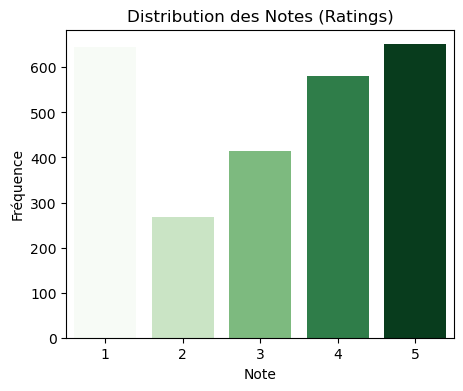

In [392]:
plt.figure(figsize=(5, 4))
sns.countplot(x='rating', data=Review, palette='Greens', hue = 'rating', legend = False)
plt.title('Distribution des Notes (Ratings)')
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.show()

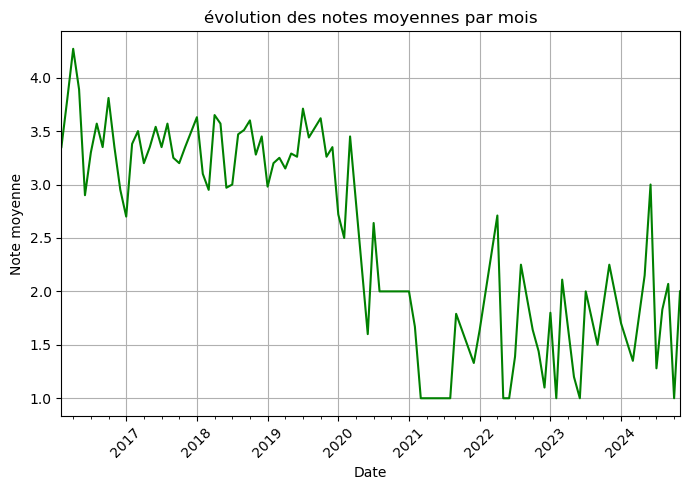

In [394]:
mons_evol = Review.groupby(Review['publishedDate'].dt.to_period('M'))['rating'].mean().round(2)

plt.figure(figsize=(7, 5))
mons_evol.plot(linestyle='-', color='g', title='évolution des notes moyennes par mois')
plt.xlabel('Date')
plt.ylabel('Note moyenne')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La note moyenne attribuée à Air France baisse avec le temps en particulier lors du passge de 2020 à 2021. Ceci laisse penser que la qualité du service fourni baisse ou que les attentes des clients augmentent tandisque la compagnie n'arrive plus à suivre.

Notre objectif étant de d'analyser puis de prédire le sentiment exprimé par le commentaire, nous décidons de regrouper les avis en en 3 classes de la manière suivante :

- "Negatif" : si le rating est 1 ou 2
- "Neutre" : si le rating est de 3
- "Positif" : si le rating est superieur ou égal à 4

In [398]:
Review['rating'] = Review['rating'].map({1 : "Negatif", 2 : "Negatif", 3 : "Neutre", 4 : "Positif", 5 : "Positif"})
sentiment_counts = Review.groupby("rating").count()

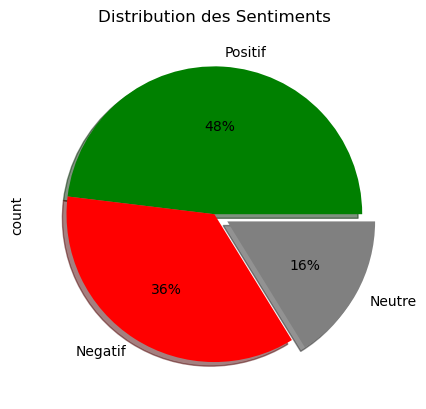

In [400]:
import matplotlib.pyplot as plt

colors = ['green', 'red', 'gray']
Review['rating'].value_counts().plot(kind='pie', explode=(0, 0, 0.1), shadow=True, autopct="%.0f%%", colors=colors)

plt.title('Distribution des Sentiments')
plt.show()

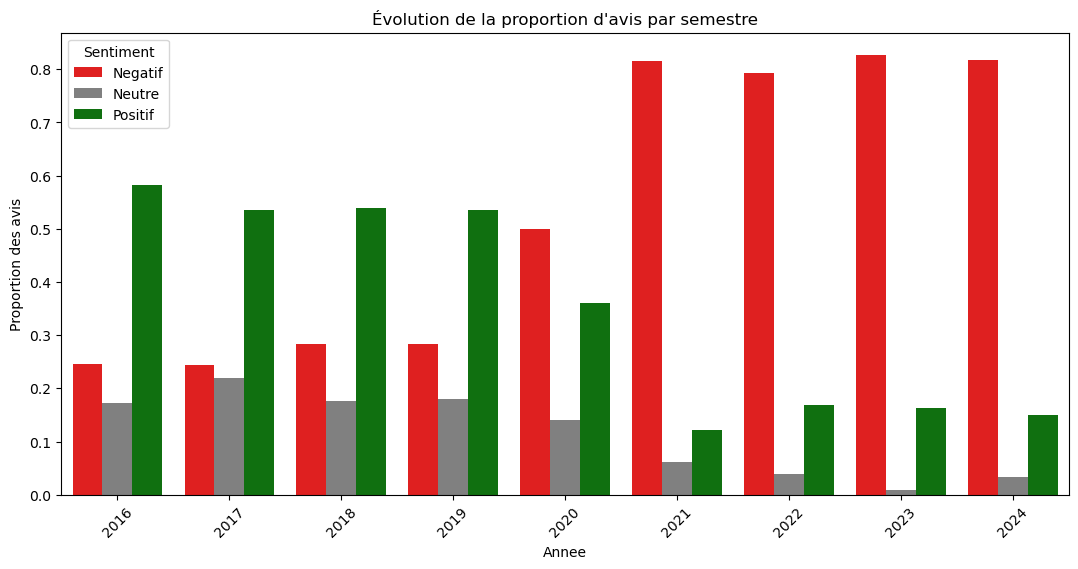

In [402]:
Review['year'] = Review['publishedDate'].dt.to_period('Y')

# proportion d'avis par année
sentiment_counts = Review.groupby(['year', 'rating']).size().reset_index(name='count')
total_counts = sentiment_counts.groupby('year')['count'].transform('sum')
sentiment_counts['proportion'] = sentiment_counts['count'] / total_counts

# 'year' en string pour un affichage plus clair
sentiment_counts['year'] = sentiment_counts['year'].astype(str)

plt.figure(figsize=(13, 6))
sns.barplot(
    x='year', 
    y='proportion', 
    hue='rating', 
    data=sentiment_counts, 
    palette={'Negatif': 'red', 'Neutre': 'gray', 'Positif': 'green'}
)
plt.title("Évolution de la proportion d'avis par semestre")
plt.xlabel("Annee")
plt.ylabel("Proportion des avis")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.show()

L'année 2021 est particulièrement mal notée par les passagers avec plus de 80% d'avis négatifs. Nous allons dans la suite (partie 1.4) explorer les données afin de mieux comprendre l'origine du probleme.

- Fréquence des mots les plus présents dans les données.

In [406]:
import matplotlib.pyplot as plt

# renvoie la frequence des n mots les plus frequents dans la phrase
def count_words(sentence, n):
  sentence = sentence.split()
  statistics = {}
  for mot in sentence:
    if mot in statistics:
      statistics[mot] += 1
    else:
      statistics[mot] = 1
  df = pd.DataFrame.from_dict(statistics, orient="index", columns=["Fréquence"])
  df = df.sort_values(by="Fréquence", ascending=False)
  return df.head(n)


words = "".join(Review.text)
count_words(words, 10)

,Fréquence
and,309
to,296
the,193
a,170
France,170
flight,152
Air,146
in,127
with,125
on,110


- Retrait des stopwords

In [23]:
from wordcloud import WordCloud, STOPWORDS

In [410]:
STOPWORDS.update(['and', 'I', 'to', 'The', 'a', 'We', 'flight', 'Air', 'France', 'Airline', 
                  'Paris', 'one', 'in', 'on']) # on enrichi la liste des stopword

stopword = "".join(STOPWORDS)

# On retire tous les mots dans stop word
def retirer(ligne, stopW) :
  ligne_split = ligne.split()
  ligne_filtree = [mot for mot in ligne_split if mot not in stopW]
  return " ".join(ligne_filtree)

Review["text"] = Review["text"].apply(retirer, args = (stopword, ))
Review[["text"]]

,text
0,WORST AIRLINE
1,Terrible experience Airfrance
2,Extremely Disappointing Experience (Flight #AF...
3,Horrible
4,Worst Flight Experience I’ve Ever Had
...,...
2555,nothing exceptional
2556,unpleasant surprise
2557,Damaged Baggage - assistance replacement refund
2558,AIR FRANCE HAS SPOILED ME!


In [412]:
import string
def retirer_ponctuation(ligne, ponctuations):
  ligne_filtrée = ligne.translate(str.maketrans('', '', ponctuations))
  return ligne_filtrée

ponctuations = string.punctuation
Review["text"] = Review["text"].apply(retirer_ponctuation, args = (ponctuations, ))
Review[["text"]].head(10)

,text
0,WORST AIRLINE
1,Terrible experience Airfrance
2,Extremely Disappointing Experience Flight AF18...
3,Horrible
4,Worst Flight Experience I’ve Ever Had
5,Really cheap experience
6,Be Mindful CarryOn baggage Weight Size
7,Terrible Customer Service Duplicate Baggage Ch...
8,Nightmare
9,Not remember previous years


Les ponctuations sont bien retirées.

On normalise à présent les commentaires à l'aide d'une technique de lemmatisation. On rappelle que cela permet de considérer le vocabulaire complet d'une langue pour appliquer une analyse morphologique aux mots.

De façon plus simple, on supprime les terminaisons des mots et on restitue la forme de base ou dictionnaire d'un mot, connue sous le nom de lemme.

In [415]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [417]:
def lemmatize(ligne):
  tokens = nltk.word_tokenize(ligne)
  lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(token) for token in tokens]
  return " ".join(lemmas)
Review["text"] = Review["text"].apply(lemmatize)

In [419]:
words = "".join(Review.text)
count_words(words, 10)

,Fréquence
service,122
good,81
airline,59
customer,52
class,43
seat,42
flight,42
food,39
experience,38
great,38


In [421]:
Review[["text"]].head()

,text
0,WORST AIRLINE
1,Terrible experience Airfrance
2,Extremely Disappointing Experience Flight AF18...
3,Horrible
4,Worst Flight Experience I ’ ve Ever Had


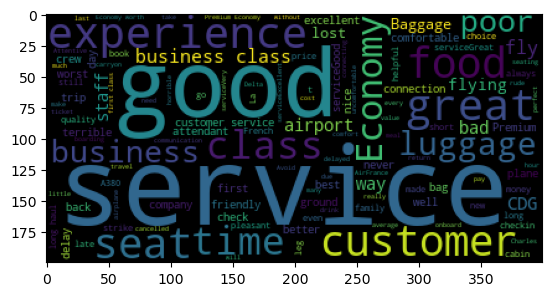

In [423]:
words = "".join(Review.text)
wordcloud = WordCloud().generate(words)
plt.imshow(wordcloud)
plt.show()

### 1.4 Analyse des avis négatifs pour comprendre l'insatisfaction
----

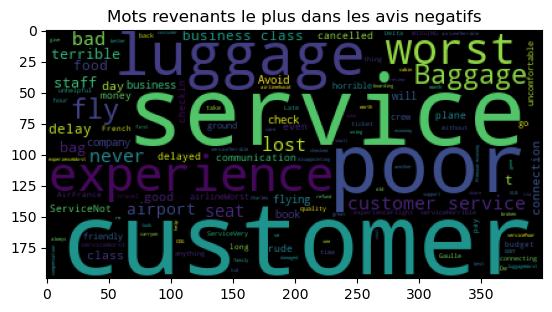

In [426]:
# On filtre les avis négatifs
negative_reviews = Review.where(Review["rating"] == "Negatif")
negative_text = "".join(negative_reviews.text.dropna())
wordcloud_ = WordCloud().generate(negative_text)

plt.imshow(wordcloud_)
plt.title("Mots revenants le plus dans les avis negatifs")
plt.show()

On constate que les mots rattachés aux avis négatifs sont :
- seat
- time
- luggage
- service
- bag

Nous allons à présent creuser davantage les commentaires avec ces mots afin d'essayer de mieux comprendre la situation.

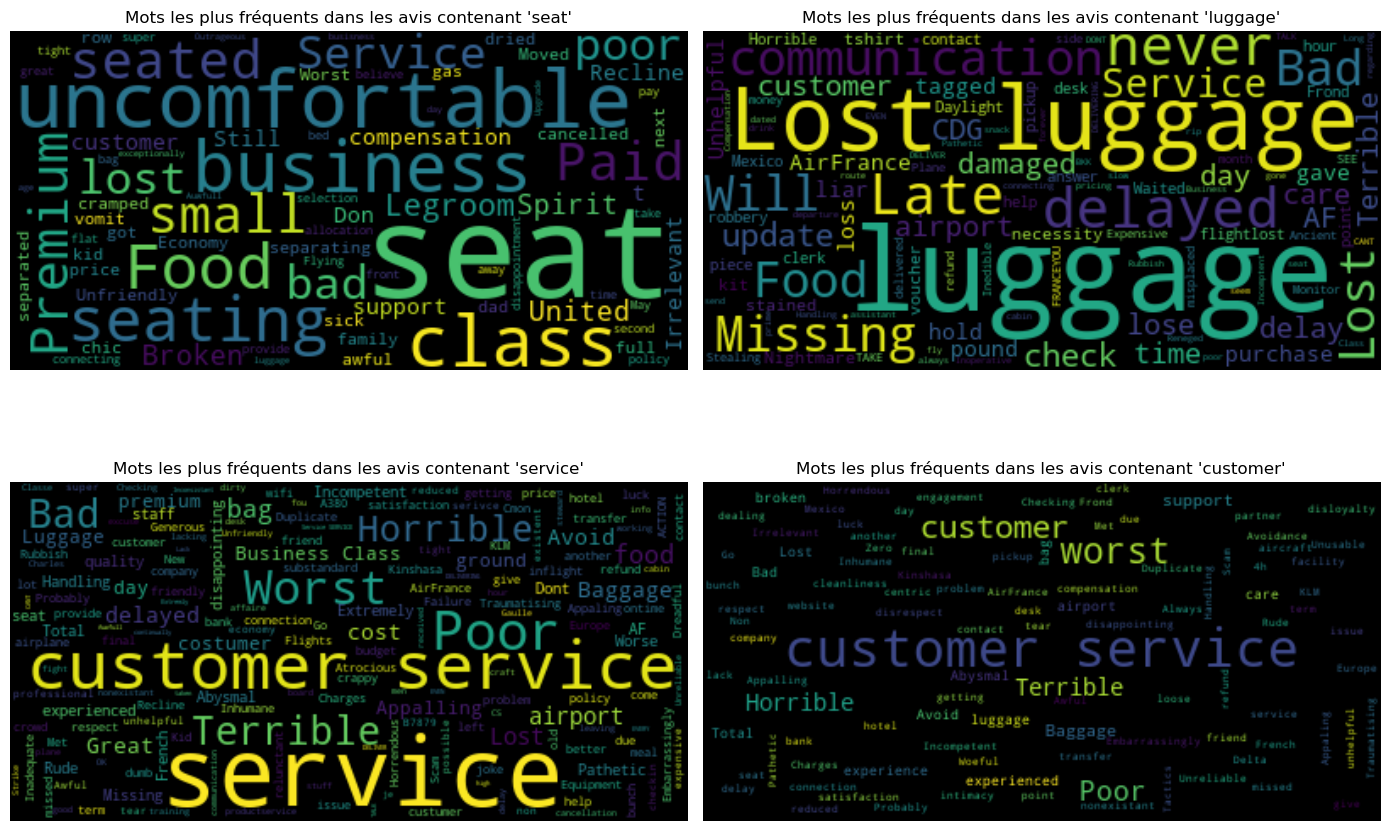

In [431]:
keywords = ["seat", "luggage", "service", "customer"]
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]  # (ligne, colonne)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for (keyword, (row, col)) in zip(keywords, positions):
    #on filtre en fonction du mot clé
    data_filtered = negative_reviews[negative_reviews.text.str.contains(keyword, case=False, na=False)].text.dropna()
    text_combined = " ".join(data_filtered)
    wordcloud = WordCloud().generate(text_combined)    
    # Affichage
    axes[row, col].imshow(wordcloud, interpolation="bilinear")
    axes[row, col].set_title(f"Mots les plus fréquents dans les avis contenant '{keyword}'")
    axes[row, col].axis("off")  # Cacher les axes

plt.tight_layout()
plt.show()

## **2 - Partie Machine Learning**


---



### 2.1 Etape 3 : Préparation pour le Machine Learning

Nous utiliserons dans la suite la méthode TF-IDF afin de transformer le texte de notre jeu de données en matrices.

> On rappelle que la méthode TF-IDF est une combinaison des méthodes combine TF (on remplace chaque mot par son nombre d'occurrences) et IDF (on remplace chaque mot par l'inverse de sa frequence dans le jeu de donnée entier).

> Son avantage est qu'elle permet de prendre en compte la rareté des mots et est plus performante que les méthodes TF et IDF prises individuellement.

> Son inconvenient est qu'elle est plus complexe à mettre en oeuvre.

### 2.2 Etape 4 : Modélisation avec du Machine Learning

In [38]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Séparons le dataset en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(Review['text'], Review["rating"], train_size=0.7, random_state=12) # 80% data train

Une fois nos donnée séparées, on transforme le X_train et le X_test en matrices **séparément** afin d'éviter le data leakage. En effet, le data leakage (fuite de données) est un problème qui se produit lorsque des informations sur les données de validation ou de test sont utilisées pour entraîner un modèle. Cela peut conduire à une surestimation de la performance du modèle sur les données réelles, car le modèle est en fait entrainé sur des données qu'il est censé prédire.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

vectorizer = TfidfVectorizer(max_features=6000) # 1000 ici est un choix arbitraire
X_sparse_train = vectorizer.fit_transform(X_train)
X_sparse_test = vectorizer.fit_transform(X_test)

# On creer une sauvegarde du vocabulaire pour le reutiliser lors du deploiement de l'application
vacabulaire = 'vectorizer.pkl'
with open(vacabulaire, 'wb') as f:
    pickle.dump(vectorizer, f)

In [41]:
import numpy as np
print(type(X_sparse_train), " de dimension ", np.shape(X_sparse_train))
print(type(X_sparse_test),  " de dimension ", np.shape(X_sparse_test))

<class 'scipy.sparse._csr.csr_matrix'>  de dimension  (1792, 6000)
<class 'scipy.sparse._csr.csr_matrix'>  de dimension  (768, 6000)


Comme on peut le voir, les matrices résultantes du processus de lémmatisation sont des matrices sparses (matrices creuses).

Afin de prédire les ratings, nous allons essayer 3 architectures de modèles de classification :

*   Arbre de decision ( DecisionTree )
*   Les méthodes de forêts aléatoires ( RandomForest )
*   Xgboosting ( XGBClassifier )



#### Modele 1 :  Arbre de décision (DecisionTree)


In [44]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [45]:
t1 = time.time()
tree = DecisionTreeClassifier(class_weight='balanced') # balanced pour prendre en compte le déséquilibre des classes à prédire
tree = tree.fit(X_sparse_train, y_train)
t2 = time.time()

timeTree = t2 - t1
# On sauvegarde le modèle en vue d'une reutilisation
#import pickle
filename = "tree.pkl"
with open(filename, "wb") as f:
    pickle.dump(tree, f)

In [46]:
# On charge le modele tree
filename = "tree.pkl"
with open(filename, "rb") as f:
    tree = pickle.load(f)

Perfomance sur les données d'entrainement

In [48]:
predicted_tree_train = tree.predict(X_sparse_train)
print(classification_report(y_train, predicted_tree_train))

              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00       645
      Neutre       1.00      1.00      1.00       303
     Positif       1.00      1.00      1.00       844

    accuracy                           1.00      1792
   macro avg       1.00      1.00      1.00      1792
weighted avg       1.00      1.00      1.00      1792



Perfomance sur les données de test

In [50]:
predicted_tree = tree.predict(X_sparse_test)
print(classification_report(y_test, predicted_tree))

              precision    recall  f1-score   support

     Negatif       0.33      0.16      0.21       269
      Neutre       0.14      0.70      0.23       112
     Positif       0.35      0.07      0.12       387

    accuracy                           0.19       768
   macro avg       0.27      0.31      0.19       768
weighted avg       0.31      0.19      0.17       768



On constate que les metriques sur le jeu d'entrainement et de test sont proches. On confirme donc l'absence de surraprentissage pour ce modèle.

#### Modele 2 :  Méthodes de forêts aléatoires ( RandomForest )

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
t1 = time.time()
rForest = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1) # balanced pour prendre en compte le déséquilibre des classes à prédire, n_jobs pour utiliser tous les coeurs dispos
rForest = rForest.fit(X_sparse_train, y_train)
t2 = time.time()

timeRForest = t2 - t1
filename2 = "rForest.pkl"
with open(filename2, "wb") as f:
    pickle.dump(rForest, f)

In [55]:
# On charge le modele random forest
filename2 = "rForest.pkl"
with open(filename2, "rb") as f:
    rForest = pickle.load(f)

Performance du random forest sur les données d'entrainement

In [57]:
predicted_rForest_train = rForest.predict(X_sparse_train)
print(classification_report(y_train, predicted_rForest_train))

              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00       645
      Neutre       1.00      1.00      1.00       303
     Positif       1.00      1.00      1.00       844

    accuracy                           1.00      1792
   macro avg       1.00      1.00      1.00      1792
weighted avg       1.00      1.00      1.00      1792



Performance du random forest sur les données de test

In [59]:
predicted_rForest = rForest.predict(X_sparse_test)
print(classification_report(y_test, predicted_rForest))

              precision    recall  f1-score   support

     Negatif       0.43      0.06      0.10       269
      Neutre       0.00      0.00      0.00       112
     Positif       0.50      0.96      0.66       387

    accuracy                           0.50       768
   macro avg       0.31      0.34      0.25       768
weighted avg       0.40      0.50      0.37       768



C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ici encore, on constate l'absence de surraprentissage. De plus les performance ici sont nettement meilleurs qu'avec l'arbre de décision. Ce qui est tout à fait logique étant donnée que les random foreste sont des aggregations d'arbre.

#### Modele 3 : Support vector machine (SVM)

#### Modele 4 : XGboosting classifier (XGBClassifier )

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

Le modèle xgboost travaille avec une variable cible necessairement relle c'est à dire dans l'ensemble {0, 1, 2, ...} cependant, notre cible représente des notes ayant 3 modalités. On va donc recoder la variable y_train et y_test.

In [65]:
y_train2 = y_train.map({"Negatif": 0, "Neutre": 1, "Positif": 2})
y_test2  = y_test.map ({"Negatif": 0, "Neutre": 1, "Positif": 2})

In [66]:
t1 = time.time()
xgb = GradientBoostingClassifier(subsample = 0.7)
xgb = xgb.fit(X_sparse_train, y_train2)
t2 = time.time()

timeGB = t2 - t1
filename3 = "xgb.pkl"
with open(filename3, "wb") as f:
    pickle.dump(xgb, f)

In [67]:
# On charge le modele xgboosting
filename3 = "xgb.pkl"
with open(filename3, "rb") as f:
    xgb = pickle.load(f)

Performance du XGBOOSTING sur les données de

In [69]:
predicted_xgb_train = xgb.predict(X_sparse_train)
print(classification_report(y_train2, predicted_xgb_train))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       645
           1       0.98      0.73      0.84       303
           2       0.92      0.99      0.95       844

    accuracy                           0.93      1792
   macro avg       0.95      0.89      0.91      1792
weighted avg       0.94      0.93      0.93      1792



Performance du rXGBOOSTING sur les données de test

In [71]:
predicted_xgb = xgb.predict(X_sparse_test)
print(classification_report(y_test2, predicted_xgb))

              precision    recall  f1-score   support

           0       0.38      0.13      0.20       269
           1       0.12      0.03      0.04       112
           2       0.50      0.85      0.63       387

    accuracy                           0.48       768
   macro avg       0.34      0.34      0.29       768
weighted avg       0.41      0.48      0.39       768



### Optimisation des hypers parametres du modele retenu

On sélectionne le modèle que l'on va retenir en fonction de la précision la plus élevée sur la classe minoritaire. Ceci est un choix bien réfléchi.

En effet, l'accuracy, en présence de données déséquilibrée comme dans notre cas aura tendance à etre très elevée en raison de la classe majoritaire. La précision compte à elle, est une mesure qui prend en compte le nombre de prédictions correctes pour une classe spécifique parmi toutes les prédictions qui ont été faites pour cette classe. Elle donne donc une meilleur information sur la performance du modèle.

Sur la base des explications précédentes, nous retenons le GRADIENT BOOSTING.

**Calibration du modèle GRADIENT BOOSTINGT**

On utilise ici une méthode qui consiste à selectionner aléatoirement un ensemble d'hyperparamètres dans un ensemble que je définie préalablement. Le meilleur modèle est choisit en fonction de la précision la plus élevée le plus élevé. Notons que ce modèle utilise une validation croisée

In [74]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

In [75]:
#param_grid = {
#    "n_estimators": randint(50, 500),
#    "max_depth": randint(1, 10)
#}

#rf_ = RandomForestClassifier(n_jobs = -1)
#rf_random_search = RandomizedSearchCV(rf_, param_distributions = param_grid, cv=5, n_jobs=-1)
#rf_random_search = rf_random_search.fit(X_sparse_train, y_train2)

### Feature importance et selection

La détermination des variables les plus importantes pour un modèle est une étape cruciale dans le processus de modélisation. Elle permet de mieux comprendre quelles caractéristiques influent le plus sur les prédictions du modèle et peut aider à améliorer la performance du modèle en identifiant les caractéristiques les plus informatives.

La selection des variables sera fera sur la base des résultats du parametre *feature_importances_*. Nous choisissons de choisir automatiquement les 30 variables les plus importantes.

<Axes: title={'center': '30 variables les plus importantes'}>

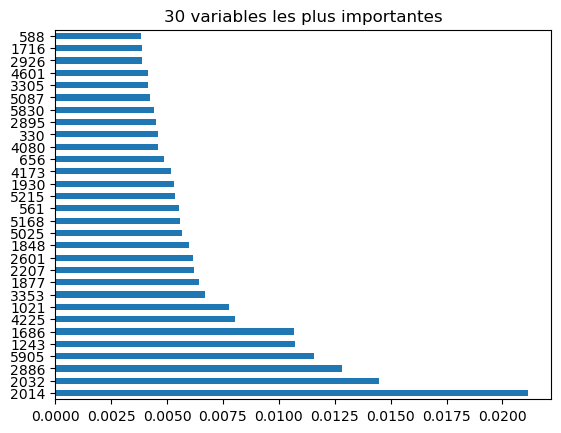

In [77]:
# On selectionne les 30 premières caractéristiques

pd.Series(rForest.feature_importances_) .nlargest(30).plot(kind='barh', title = "30 variables les plus importantes")

In [78]:
X_sparse_train2 = X_sparse_train #[:, top_features_boolean]
X_sparse_test2  = X_sparse_test  #[:, top_features_boolean]

## Partie Deep Learning simple


---



### 3.1 Etape 5 : Modèles neuronaux simples

On décide de construire un réseau de neuronne selon les caractéristiques suivantes :

- Un learning rate par défaut
- 2 couches (64 puis 32 neurones) avec fonction d’activation ReLU
- Une couche finale de 3 neurone avec une fonction d’activation finale sigmoide (puisqu'il s'agit d'une classification)
- Un optimizer "Adam"

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

In [82]:
modelneurone = tf.keras.Sequential()

modelneurone.add(keras.layers.Dense(64, activation="relu", input_shape=(X_sparse_train2.shape[1], )))
modelneurone.add(keras.layers.Dense(32, activation="relu"))
modelneurone.add(keras.layers.Dense(3, activation="softmax"))
modelneurone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelneurone.summary()

C:\Users\alexa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         384,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 386,243 (1.47 MB)

 Trainable params: 386,243 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
XX_sparse_train2 = X_sparse_train2.toarray()
yy_train = np.array(y_train.map({"Negatif": 0, "Neutre": 1, "Positif": 2})) # on encode les labels
yy_train = to_categorical(yy_train, num_classes=3) # On utilise le one hot encoding pour fiter avec la derniere couche du réseau ci-dessus

t1 = time.time()
modelneurone.fit(XX_sparse_train2, yy_train, epochs=15, batch_size = 64)
t2 = time.time()
timeNeurone1 = t2 - t1

Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5027 - loss: 1.0737
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7079 - loss: 0.8639
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7977 - loss: 0.5768
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8540 - loss: 0.3555
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9642 - loss: 0.2051
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.1004
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0514
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0307
Epoch 9/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0189
Epoch 10/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0125
Epoch 11/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0092
Epoch 12/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - 

In [84]:
filename4 = "neural.pkl"
#with open(filename4, "wb") as f:
#    pickle.dump(modelneurone, f)

# On charge le reseau entrainé
filename3 = "neural.pkl"
#with open(filename3, "rb") as f:
#    modelneurone = pickle.load(f)

In [85]:
y_pred_neuronal_train = modelneurone.predict(X_sparse_train2.toarray())
y_pred_neuronal_train

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[3.7188012e-05, 2.0183752e-05, 9.9994266e-01],
       [2.2180809e-03, 9.9403340e-01, 3.7485047e-03],
       [2.7393405e-03, 9.9639708e-01, 8.6358405e-04],
       ...,
       [9.8430562e-01, 8.8682082e-03, 6.8261330e-03],
       [5.5651431e-05, 1.8601454e-03, 9.9808419e-01],
       [2.5704767e-06, 4.6207331e-04, 9.9953532e-01]], dtype=float32)

On constate que le réseau de neuronne prédit, pour chaque observations, la probabilité d'appartenir à une classe (0, 1 ou 2). Puisque nous souhaitons prédire des classes, nous considérons que la bonne classe est celle ayant la probabilité la plus élevée.

In [87]:
y_pred_neuronal_train = y_pred_neuronal_train.argmax(-1)

Performance sur le train

In [89]:
print(classification_report(np.array(y_train.map({"Negatif": 0, "Neutre": 1, "Positif": 2})), y_pred_neuronal_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       645
           1       1.00      1.00      1.00       303
           2       1.00      1.00      1.00       844

    accuracy                           1.00      1792
   macro avg       1.00      1.00      1.00      1792
weighted avg       1.00      1.00      1.00      1792



Performance sur le test

In [91]:
y_pred_neuronal = modelneurone.predict(X_sparse_test2.toarray())
y_pred_neuronal = y_pred_neuronal.argmax(-1)
yy_test = y_test.map({"Negatif": 0, "Neutre": 1, "Positif": 2})
print(classification_report(yy_test, y_pred_neuronal))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.41      0.28      0.33       269
           1       0.14      0.03      0.04       112
           2       0.52      0.75      0.61       387

    accuracy                           0.48       768
   macro avg       0.35      0.35      0.33       768
weighted avg       0.42      0.48      0.43       768



Ce reseau de neurone donne des performances équivalentes à notre meilleur modèle de ML optimisé sans qu'il n'est été spécialement optimisé. La selection des variables précédente nous a permit d'avoir un modèle rapide à entrainer et deja performant.

On remarque encore l'absence de surraprentissage en regardant les performances sur le train et le test.


## Etape 6 : Partie Deep Learning récurrent
###  Modèles récurrents simples
---

Les réseaux de reuronnes récurrents sont particulièrement efficaces pour traiter des données séquentielles comme du texte, car ils peuvent prendre en compte les dépendances dans les données. Cela leur permet de capturer des relations complexes comme la dépendances entre 2 mots.

Concernant les limites des modèles de deep learning "normaux" (sans récurrence) lorsqu'il s'agit de prédire du texte est leur incapacité à capturer les dépendances dans les données séquentielles. Ceci peut entraîner une perte d'information importante, en particulier dans les données textuelles où le sens d'un mot peut dépendre du contexte dans lequel il est utilisé.


### Implémentation d'un RNN simple

On va creer une architecture simple contenant une couche de réseaux de neurone récurrent simple (simple RNN) avec très peu de neurone et une couche de sortie avec fonction d'activation softmax.


In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN

In [95]:
model_rnn = Sequential([
    SimpleRNN(40, input_shape=(30, 1)),
    Dense(3, activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_rnn.summary()

C:\Users\alexa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 40)                  │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             123 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,803 (7.04 KB)

 Trainable params: 1,803 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
t1 = time.time()
model_rnn.fit(XX_sparse_train2, yy_train, epochs=15, batch_size = 64)
t2 = time.time()
timeSimpleRNN = t2 - t1

Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4406 - loss: 1.0595
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4637 - loss: 1.0330
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4660 - loss: 1.0282
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4743 - loss: 1.0134
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4794 - loss: 1.0218
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4629 - loss: 1.0292
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4682 - loss: 1.0121
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4623 - loss: 1.0329
Epoch 9/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4806 - loss: 1.0275
Epoch 10/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4660 - loss: 1.0232
Epoch 11/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4726 - loss: 1.0141
Epoch 12/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4807 - lo

On constate que le temps de compilation est très élevé pour ce modèle par rapport aux précédent. Nous allons maintenant rajouter une couche d'interpretabilité à ce modèle. L'objectif de cette couche est

In [98]:
filename5 = "RNN.pkl"
#with open(filename5, "wb") as f:
#    pickle.dump(model_rnn, f)

# On charge le reseau entrainé
#filename5 = "RNN.pkl"
#with open(filename5, "rb") as f:
#    model_rnn = pickle.load(f)

Performance sur le test

In [100]:
y_pred_rnn = model_rnn.predict(X_sparse_test2.toarray())
y_pred_rnn = y_pred_rnn.argmax(-1)
print(classification_report(yy_test, y_pred_rnn))

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       269
           1       0.00      0.00      0.00       112
           2       0.50      1.00      0.67       387

    accuracy                           0.50       768
   macro avg       0.17      0.33      0.22       768
weighted avg       0.25      0.50      0.34       768



C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Etape 6 : Deploiement
###  Tableau récapitulatif pour la Comapraison
---

In [102]:
from sklearn.metrics import accuracy_score, log_loss

In [103]:
data = {
    'Decision tree': [timeTree, accuracy_score(y_test, predicted_tree)],#[timeTree, accuracy_score(y_test, predicted_tree)],
    'Random forest': [timeRForest, accuracy_score(y_test, predicted_rForest)],#[timeRForest, accuracy_score(y_test, predicted_rForest)],
    'GB'           : [timeGB, accuracy_score(y_test2, predicted_xgb)],
    'RN'           : [timeNeurone1, accuracy_score(yy_test, y_pred_neuronal)], #timeNeurone1
    'RN récurrent' : [timeSimpleRNN, accuracy_score(yy_test, y_pred_rnn)]#[timeSimpleRNN, 0.94]
}

# Index des lignes
index = ['Temps exécution (s)', 'Accuracy']

# Création du DataFrame
df = pd.DataFrame(data, index=index)
df

,Decision tree,Random forest,GB,RN,RN récurrent
Temps exécution (s),1.424615,3.437934,29.172336,5.911671,503.869285
Accuracy,0.191406,0.501302,0.477865,0.480469,0.503906


# Bonus personnel : Utilisation de package SentimentIntensityAnalyzer

---

Dans cette partie nous avons voulu rajouter une partie personnellement en mettant en application le modèle SentimentIntensityAnalyzer du package nltk. Nous l'avons également intégrer au modèle que nous avons déployé.

In [105]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [106]:
sia = SentimentIntensityAnalyzer()
def sentiment_predit(text):
    sentiment_ratings = sia.polarity_scores(text)
    lst = list(sentiment_ratings.values())[0:3]
    max_value = np.max(lst)
    index_val = lst.index(max_value)
    if index_val==0:
      return ("Negatif", lst)
    elif index_val==1:
      return ("Neutre", lst)
    else:
      return ("Positif", lst)

In [107]:
y_pred_Analyzer = []
for i in range(X_test.shape[0]):
  y_pred_Analyzer.append(sentiment_predit(X_test.iloc[i])[0])

y_pred_Analyzer[0:6]

['Neutre', 'Neutre', 'Neutre', 'Positif', 'Neutre', 'Neutre']

In [108]:
print(classification_report(y_test, y_pred_Analyzer))

              precision    recall  f1-score   support

     Negatif       0.86      0.02      0.04       269
      Neutre       0.16      0.97      0.28       112
     Positif       0.98      0.24      0.39       387

    accuracy                           0.27       768
   macro avg       0.67      0.41      0.24       768
weighted avg       0.82      0.27      0.25       768



Demonstration sur un texte

In [110]:
sentiment = "I dislike air france this compagny good but ennoying"
sentiment_predit(sentiment)

('Neutre', [0.185, 0.615, 0.2])

> De cette analyse, on constate que les mots les plus fréquents sont des articles et des prépositions. Ils n'apportent donc pas beaucoup d'informations sur le sentiment que l'on veut prédire.

> Les stopword sont des mots frequents du language n'ayant pas de réelle signification. On dit aussi qu'ils ne sont pas porteurs de sens.

> C'est le cas des mots les plus fréquents que l'on vient d'observer.


Dans la suite, on va nettoyer les données en retirants ces stopswords.

###  **1.2 Etape 2 : Nettoyage**

---